In [1]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd
import matplotlib.patches as mpatches

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import helper

import matplotlib.style as style
plt.style.use("markerr.mplstyle")

In [2]:
# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)
target_zips = pd.read_csv('target.csv', index_col = 0)



In [3]:
# lists of relevent zipcodes
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())

# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# # limiting to the inidvidual regions of interest
# houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
# paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
# san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
# austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
# dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     different_metros[metro].plot(ax=zip_boundry_map, zorder=2, legend=False, column = 'GEOID10', cmap='hsv')

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = different_metros[metro].total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro)
#     plt.show()

In [4]:
zori_pred_lasso = pd.read_csv('zori_pred_lasso_base.csv',
                             index_col = 0, parse_dates = ['Time'])

zori_pred_rf = pd.read_csv('rand_forest_backtest_outlook.csv',
                           index_col = 0, parse_dates = ['Time'])

zori_pred_xg = pd.read_csv('xgboost_backtest_outlook.csv',
                           index_col = 0, parse_dates = ['Time'])

zori_pred_cat = pd.read_csv('cb_forecast.csv',
                           index_col = 0, parse_dates = ['Time'])

In [6]:
zori_pred_cat.columns = ['Time','zip_code','zori_ssa']
zori_pred_cat['model_code'] = 'cat'

In [6]:
pd.set_option('display.max_rows', 150)

In [8]:
zori_pred = pd.concat([zori_pred_lasso, zori_pred_rf, zori_pred_xg,zori_pred_cat]).reset_index(drop = True)
zori_pred

,Time,zip_code,zori_ssa,model_code
0,2014-01-01,77494.0,1390.000000,actual_values
1,2014-02-01,77494.0,1387.000000,actual_values
2,2014-03-01,77494.0,1384.000000,actual_values
3,2014-04-01,77494.0,1381.000000,actual_values
4,2014-05-01,77494.0,1379.000000,actual_values
...,...,...,...,...
37536,2022-07-01,78245.0,1354.346458,cat
37537,2022-07-01,77429.0,1702.090845,cat
37538,2022-07-01,75052.0,1600.548573,cat
37539,2022-07-01,78741.0,1435.654544,cat


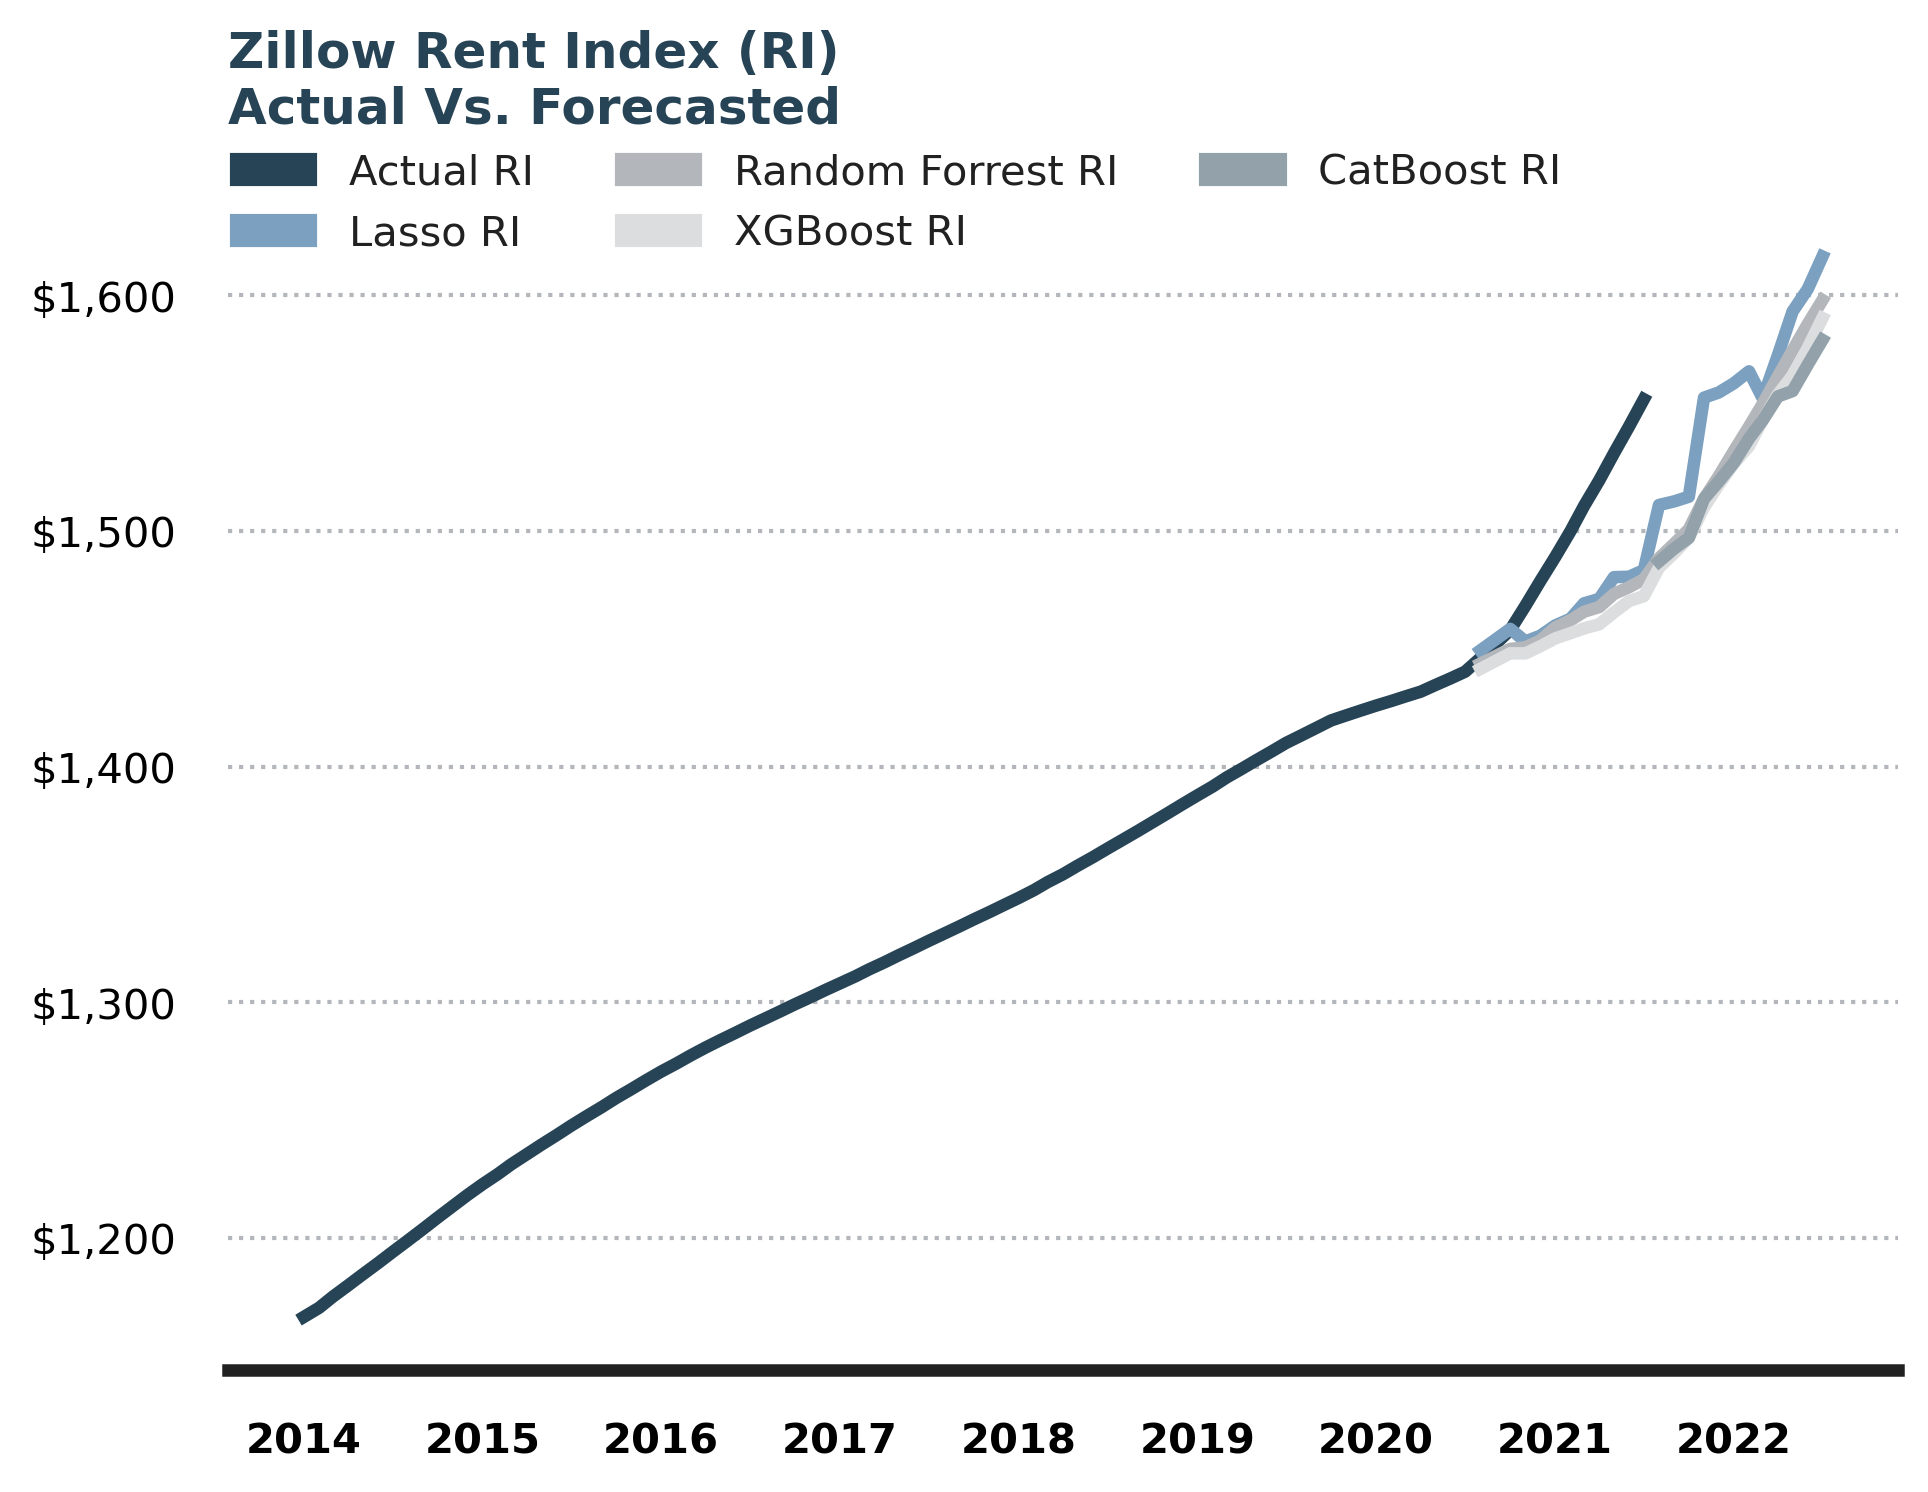

In [18]:
colors = ['#274456','#7BA0C0', '#B3B6BA','#dbddde','#93a1aa']


fig, ax = plt.subplots()
g = sns.lineplot(data = zori_pred, 
                 x = 'Time',y = 'zori_ssa', 
                 hue = 'model_code', 
                 ci = None, 
                 linewidth=3,
                ax = ax, 
                 palette = colors
                )
# axis spine options are ['left','right','bottom','top']
ax.spines['bottom'].set_visible(True)
# make the highlighted features bold. should be the same side with the visible spine
plt.xticks(fontweight='bold')
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'x')

g.set(xlabel='', ylabel='',title=f'Zillow Rent Index (RI)\nActual Vs. Forecasted \n')

# legend
acutal_patch = mpatches.Patch(color=colors[0], 
                           label='Actual RI')
lasso_patch = mpatches.Patch(color=colors[1], 
                           label='Lasso RI')
rf_patch = mpatches.Patch(color=colors[2], 
                           label='Random Forrest RI')
xg_patch = mpatches.Patch(color=colors[3], 
                           label='XGBoost RI')
cat_patch = mpatches.Patch(color=colors[4], 
                           label='CatBoost RI')
plt.legend(handles=[acutal_patch,lasso_patch,rf_patch,xg_patch,cat_patch],
           loc='center left', 
           bbox_to_anchor=(-0.02, 1),frameon=False,ncol=3,
                title = '')

ax.yaxis.set_major_formatter('${x:,.0f}')

# add information from before 2016
# can we have this be percent increase
# fix the y axis to have dollar signs
plt.show()

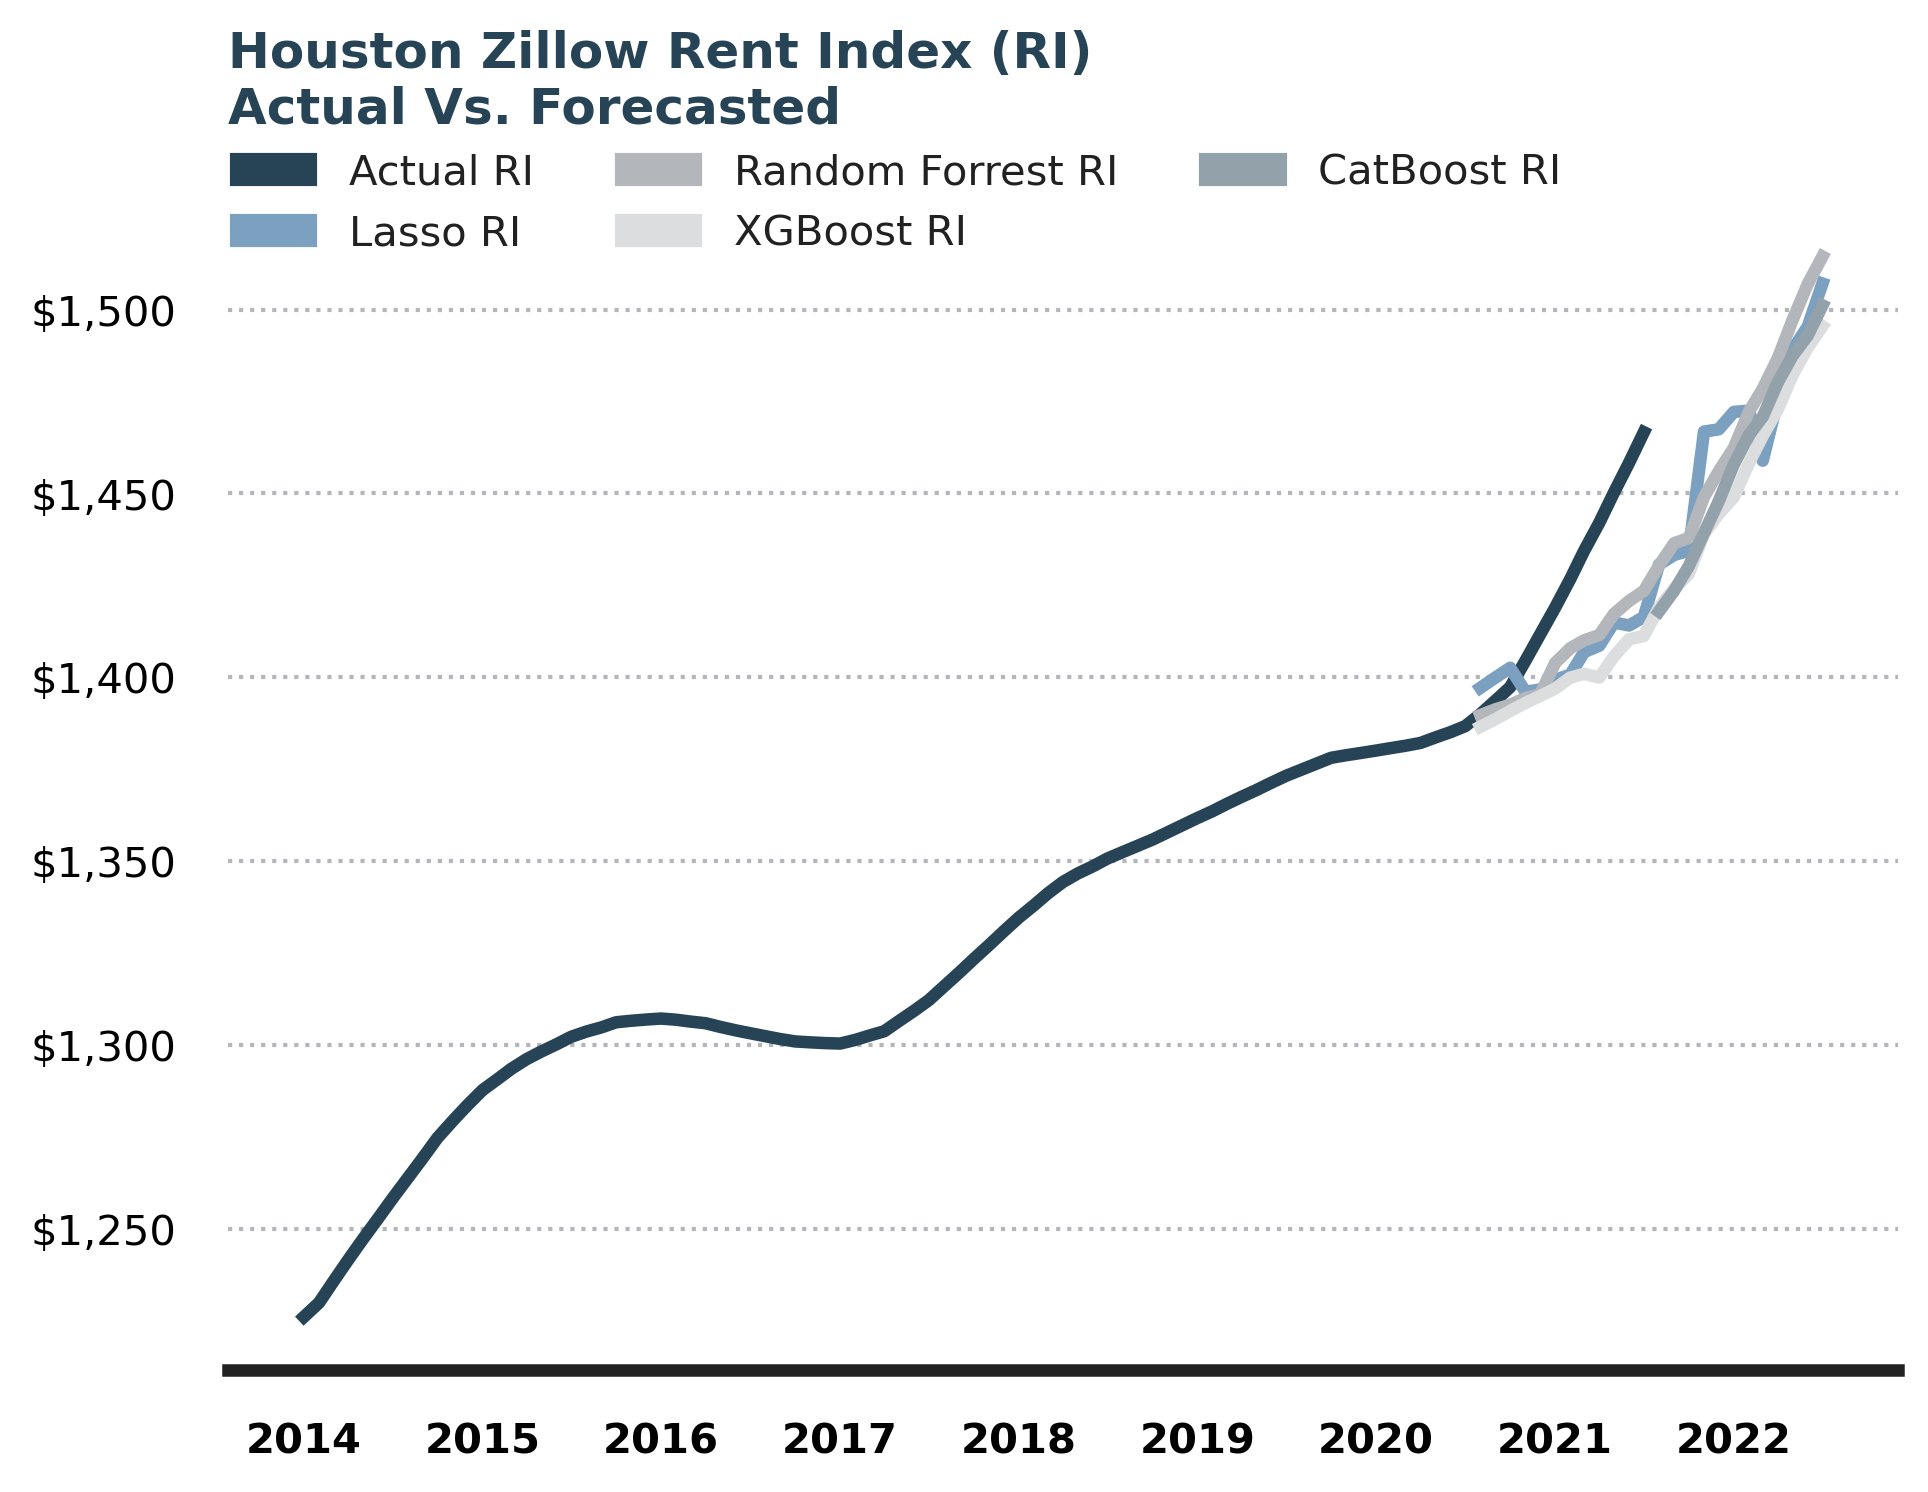

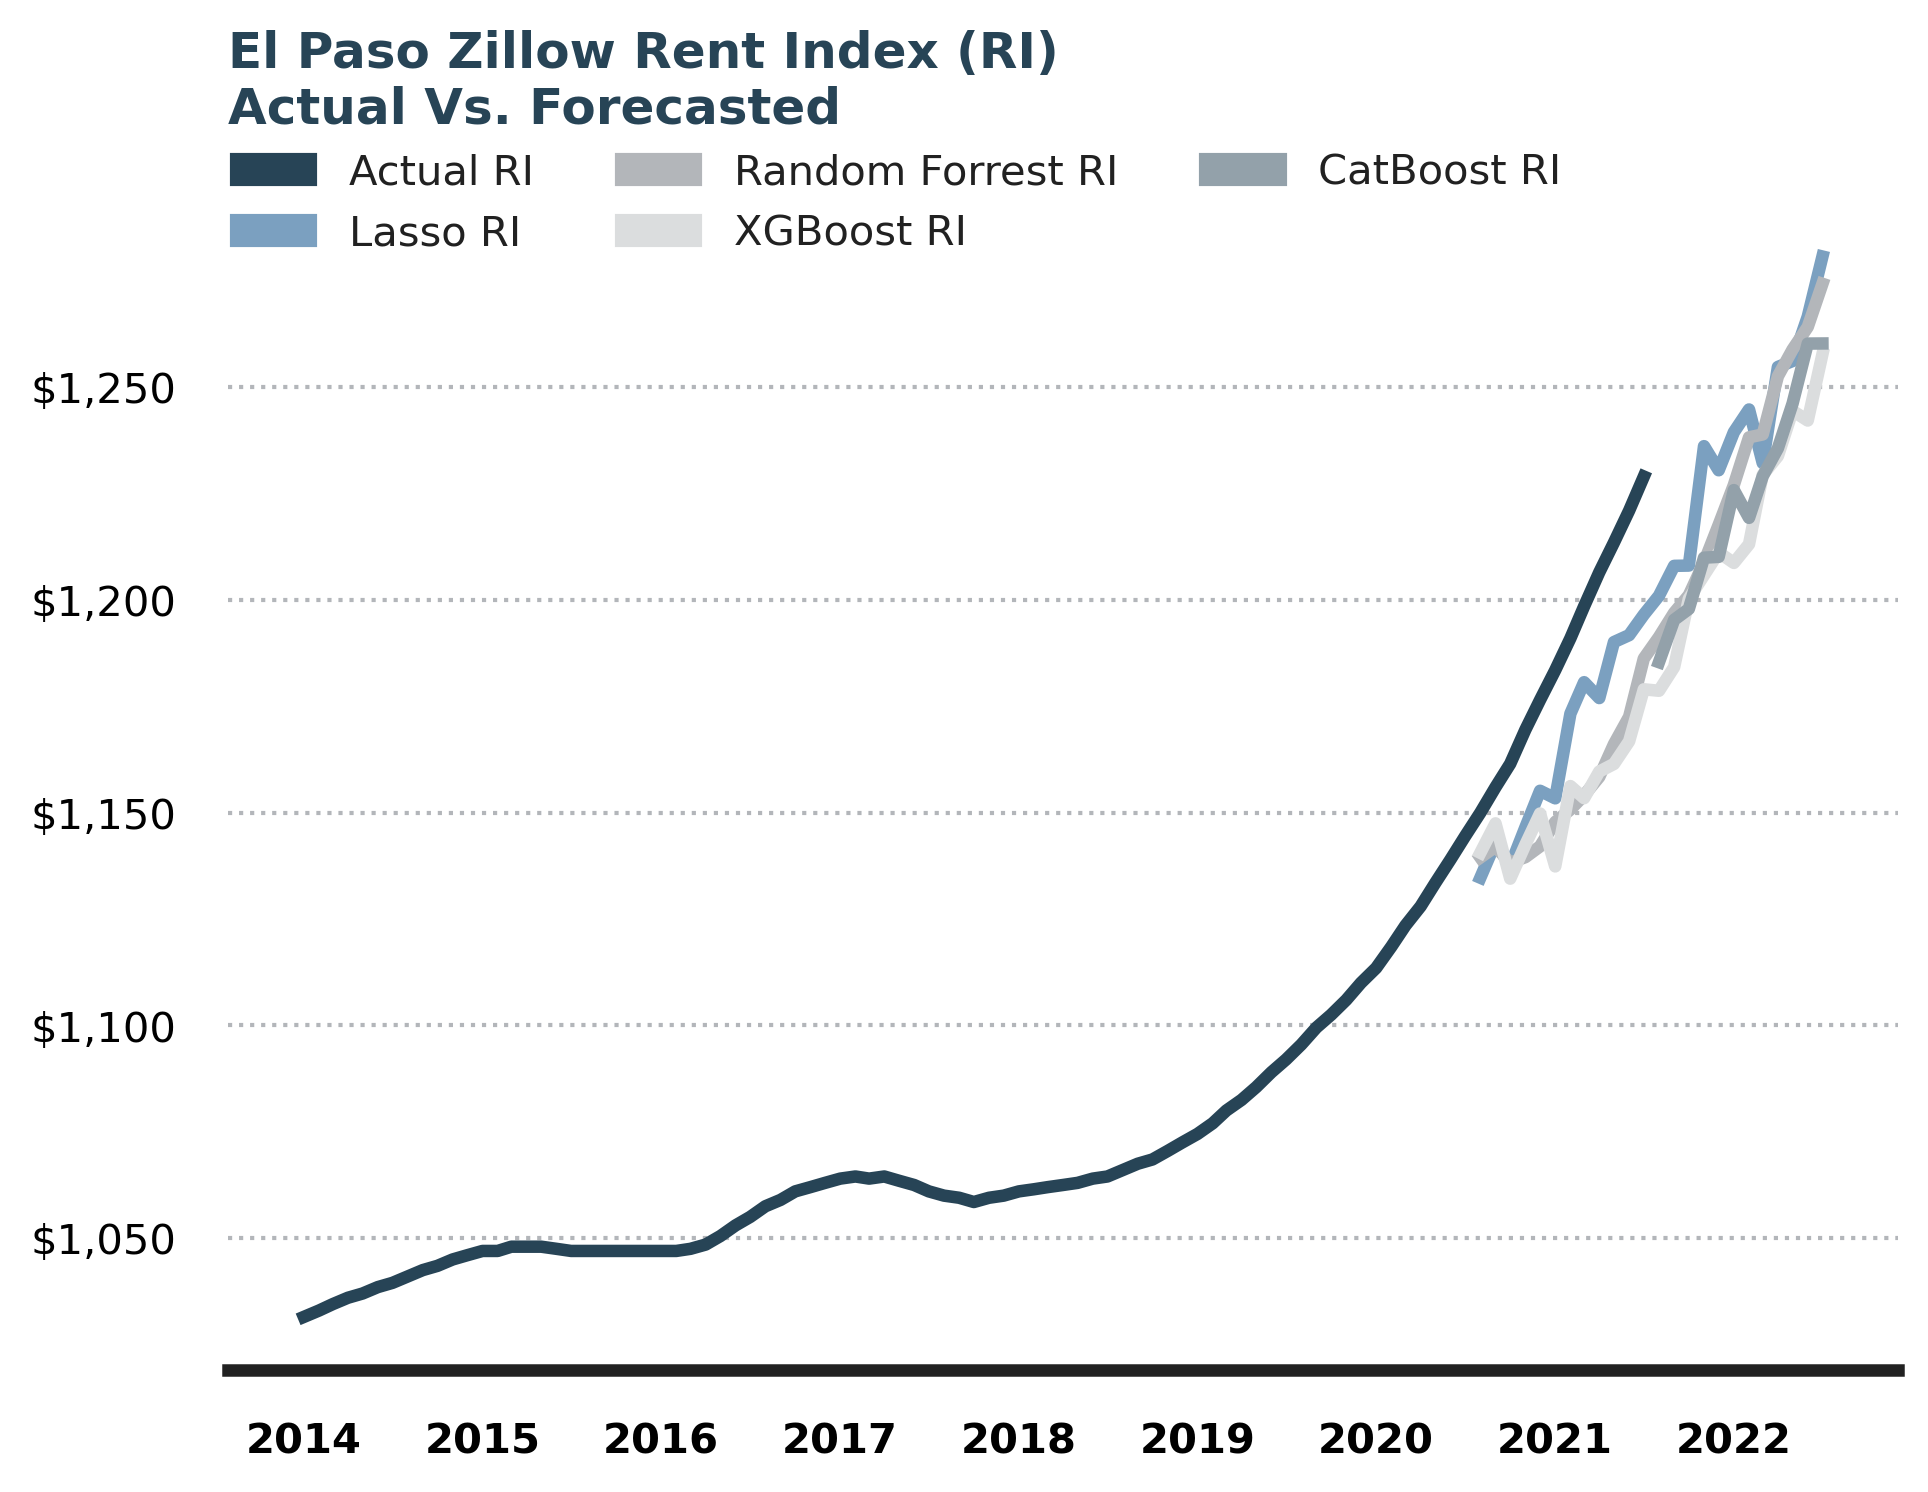

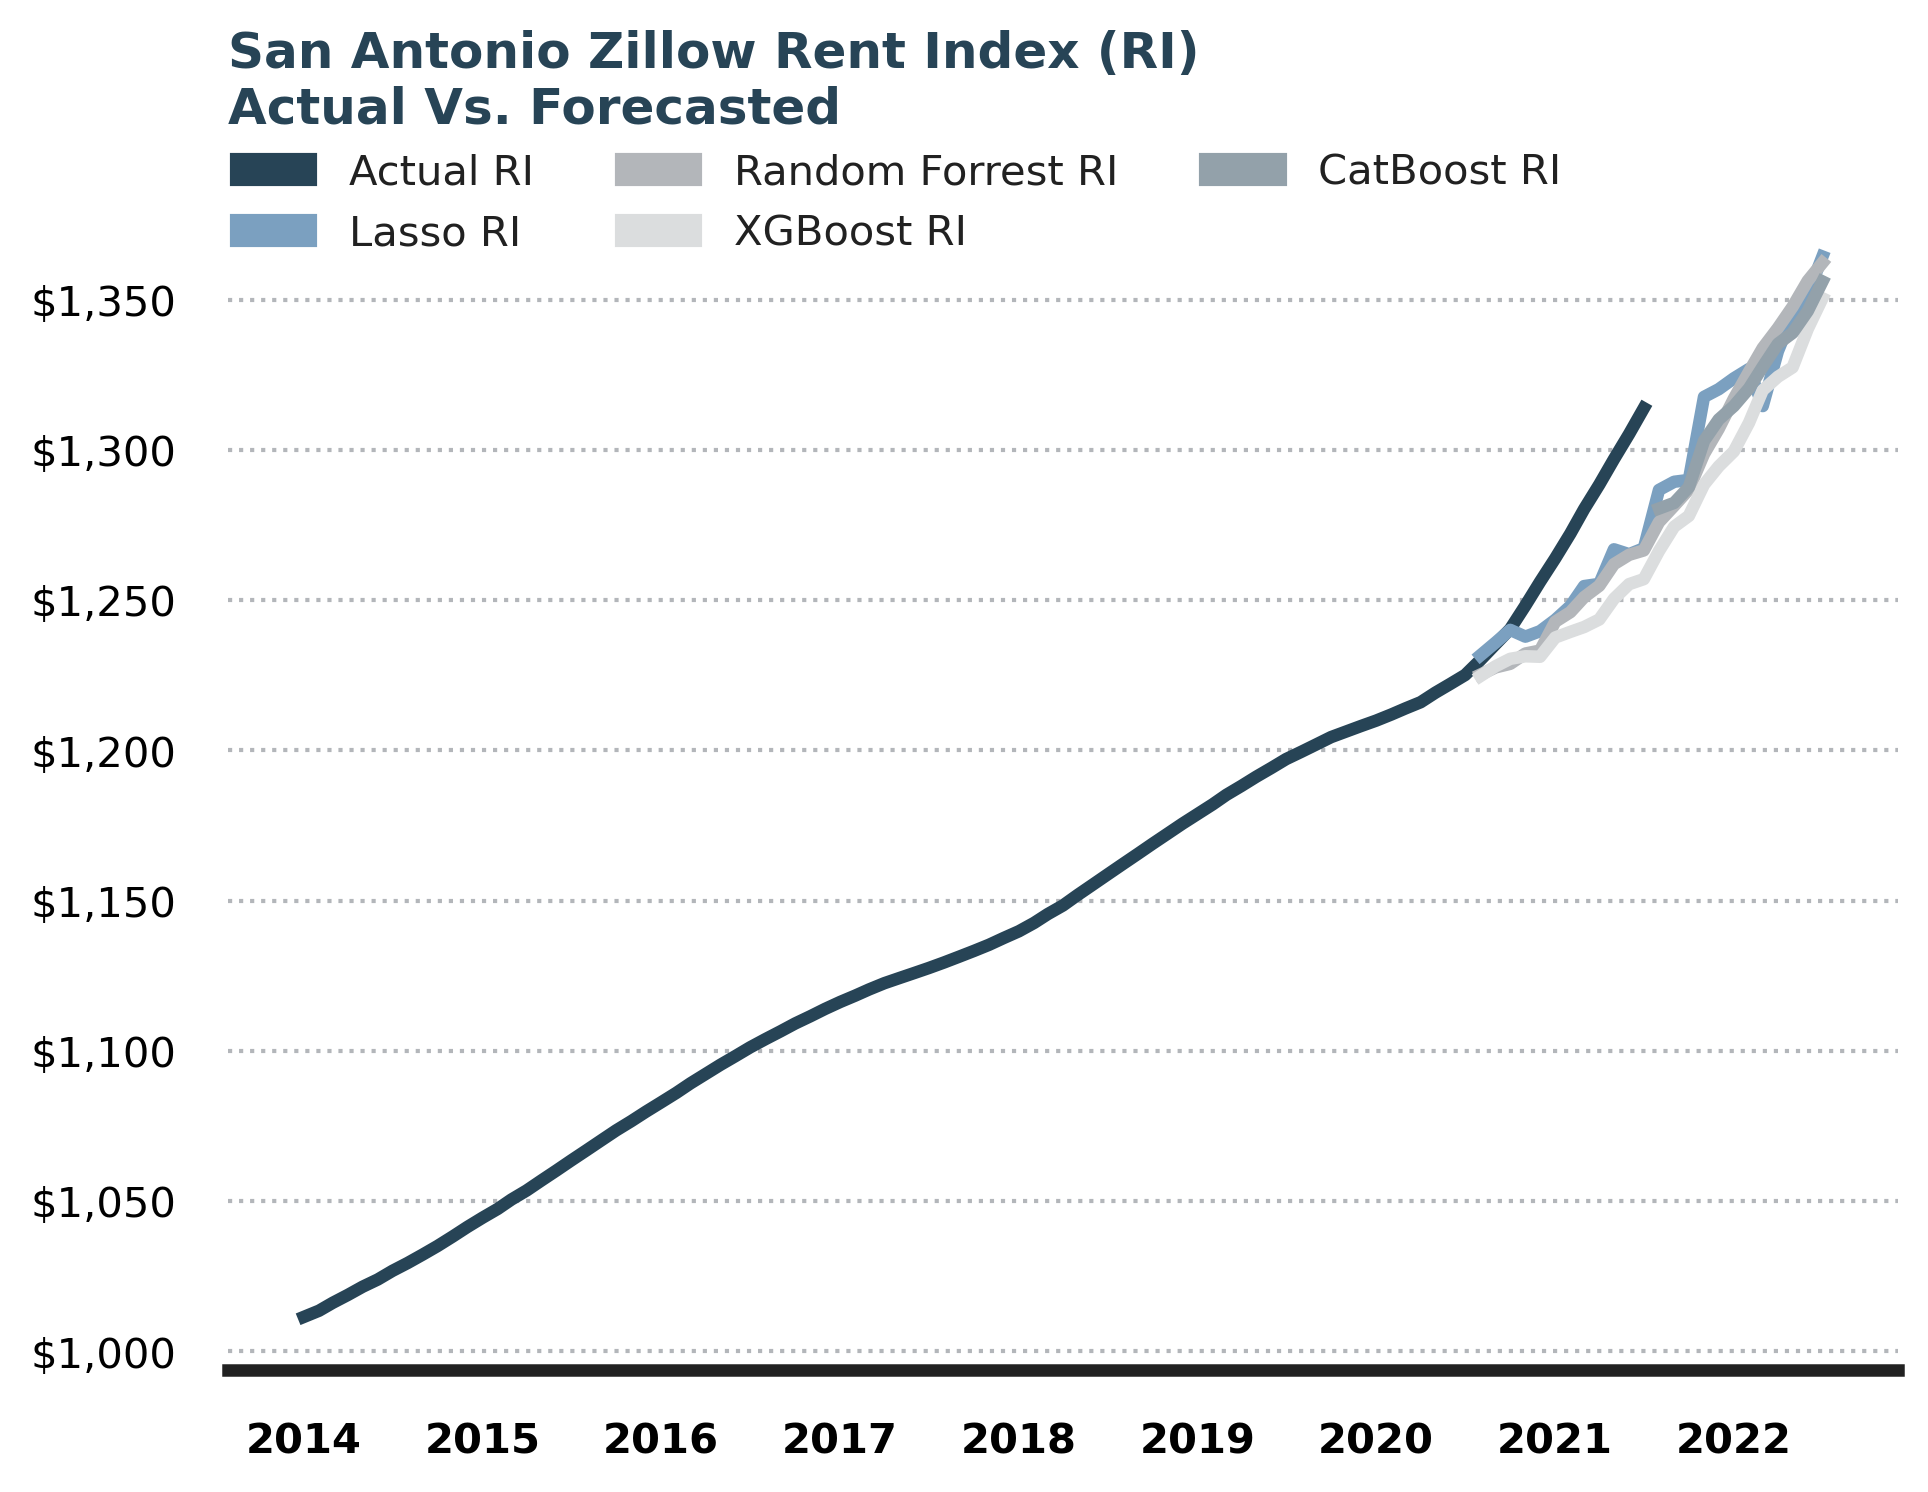

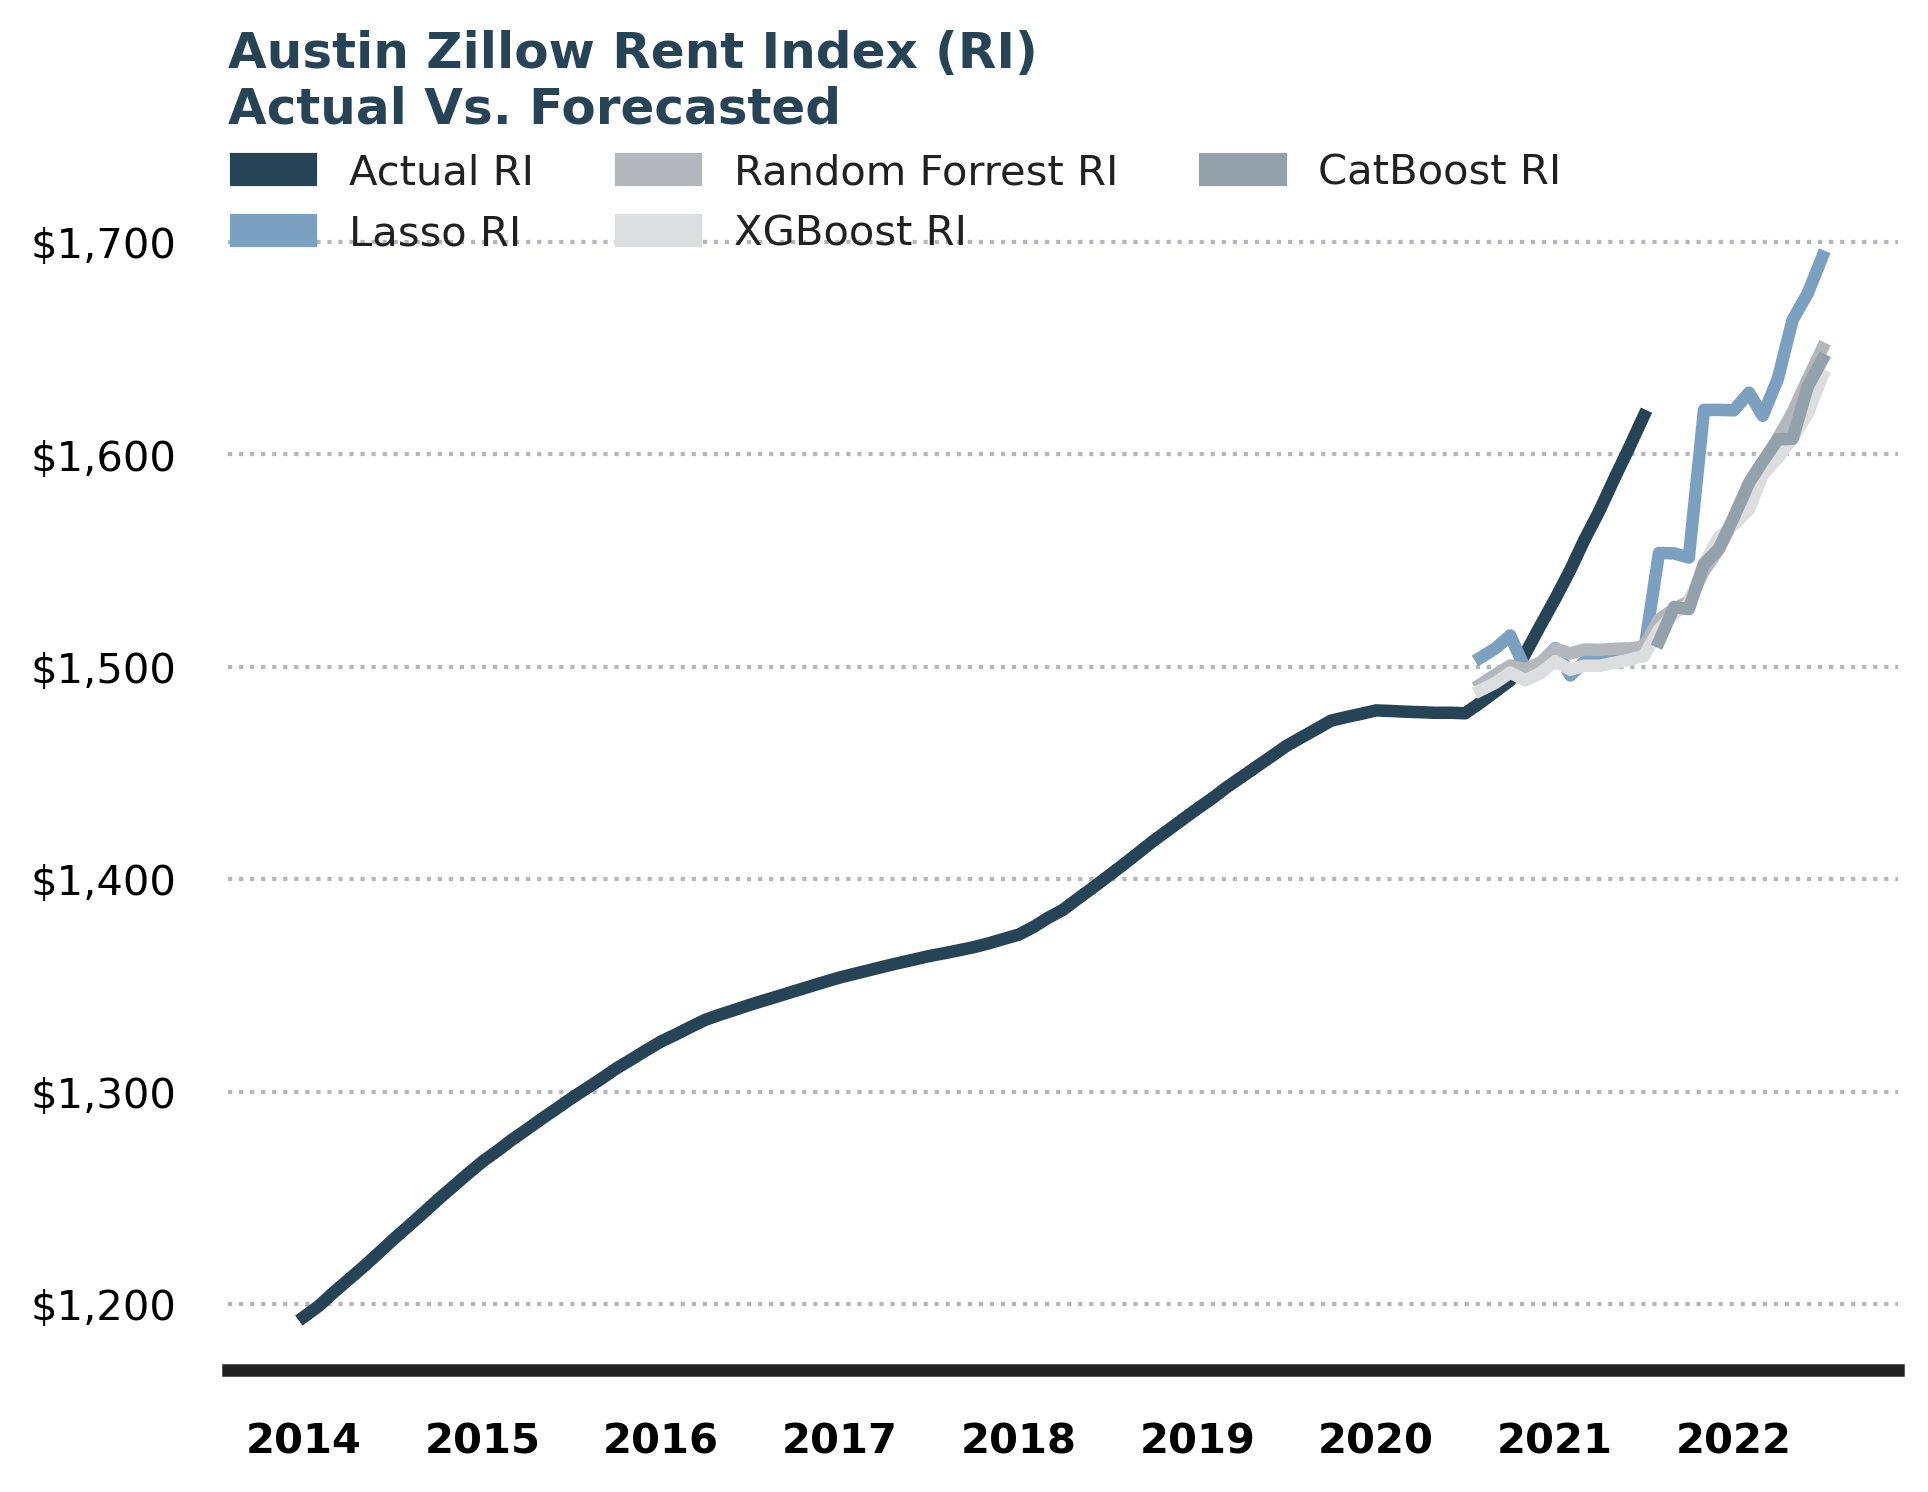

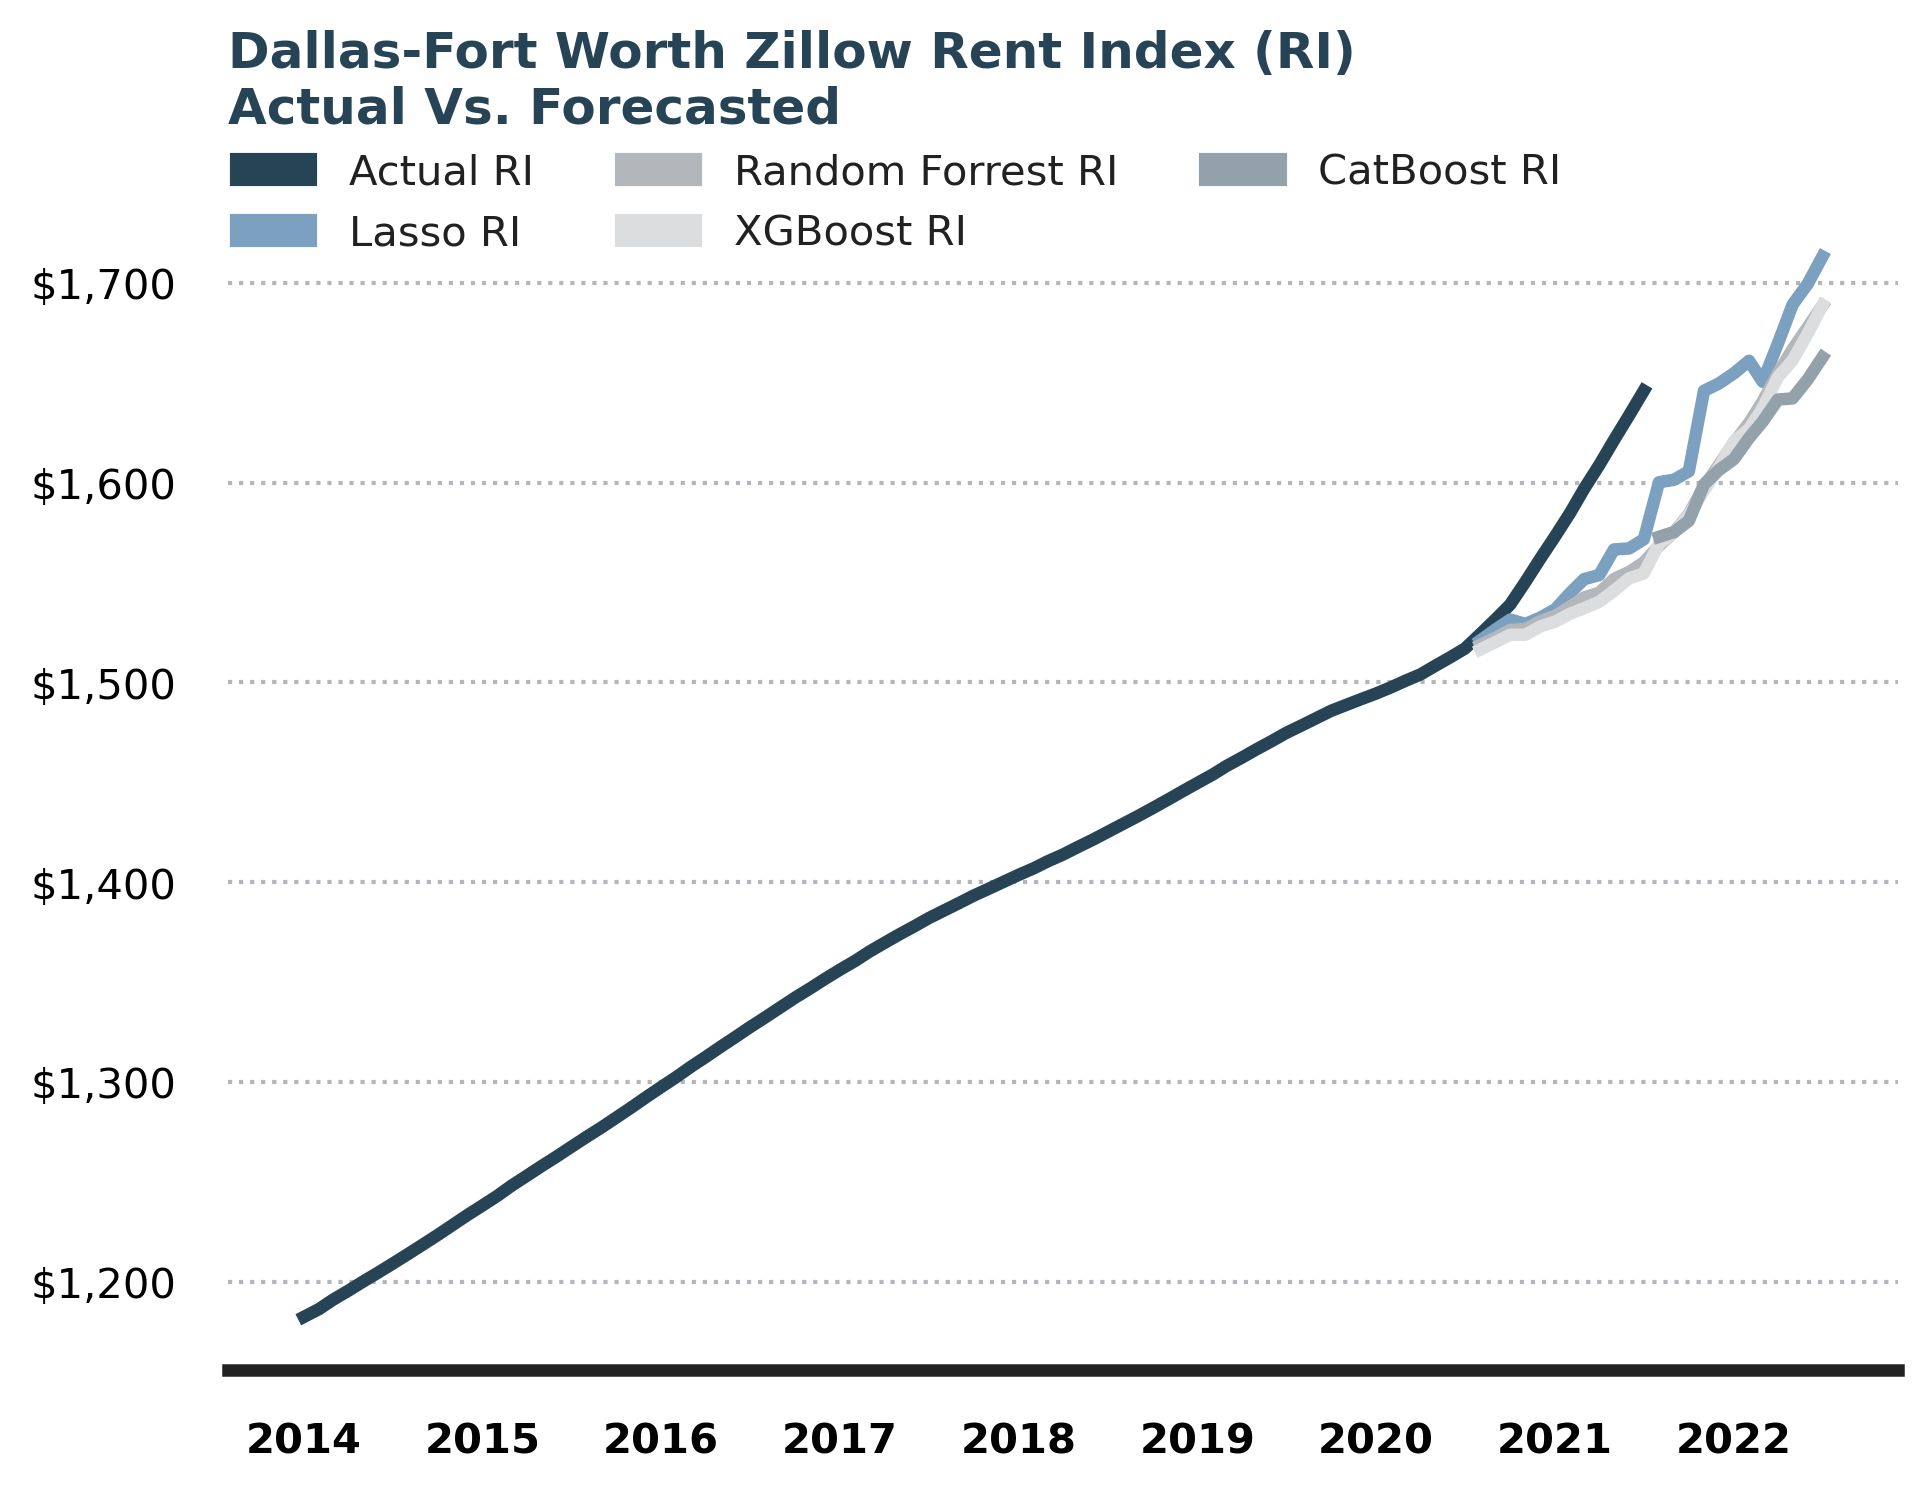

In [17]:
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips_list, 
                    'El Paso' : paso_zips_list, 
                    'San Antonio' : san_zips_list, 
                    'Austin' : austin_zips_list, 
                    'Dallas-Fort Worth' : dallas_zips_list}

for metro in different_metros:
    metro_zori_pred = zori_pred.loc[zori_pred.loc[:,'zip_code'
                                                 ].isin(different_metros[metro]),:]
    
    colors = ['#274456','#7BA0C0', '#B3B6BA','#dbddde','#93a1aa']
    fig, ax = plt.subplots()
    g = sns.lineplot(data = metro_zori_pred, 
                     x = 'Time',y = 'zori_ssa', 
                     hue = 'model_code', ci = None, linewidth=3,
                    ax = ax, 
                     palette = colors
                    )
    # axis spine options are ['left','right','bottom','top']
    ax.spines['bottom'].set_visible(True)
    # make the highlighted features bold. should be the same side with the visible spine
    plt.xticks(fontweight='bold')
    # remove x axis grid lines that were cluttering the graph
    ax.grid(b = None, axis = 'x')

    g.set(xlabel='', ylabel='',title=f'{metro} Zillow Rent Index (RI)\nActual Vs. Forecasted \n')

    # legend
    acutal_patch = mpatches.Patch(color=colors[0], 
                               label='Actual RI')
    lasso_patch = mpatches.Patch(color=colors[1], 
                               label='Lasso RI')
    rf_patch = mpatches.Patch(color=colors[2], 
                               label='Random Forrest RI')
    xg_patch = mpatches.Patch(color=colors[3], 
                               label='XGBoost RI')
    cat_patch = mpatches.Patch(color=colors[4], 
                               label='CatBoost RI')
    plt.legend(handles=[acutal_patch,lasso_patch,rf_patch,xg_patch,cat_patch],
               loc='center left', 
               bbox_to_anchor=(-0.02, 1),frameon=False,ncol=3,
                    title = '')

    ax.yaxis.set_major_formatter('${x:,.0f}')
    plt.show()

#### non forecasted. just on the test time frame

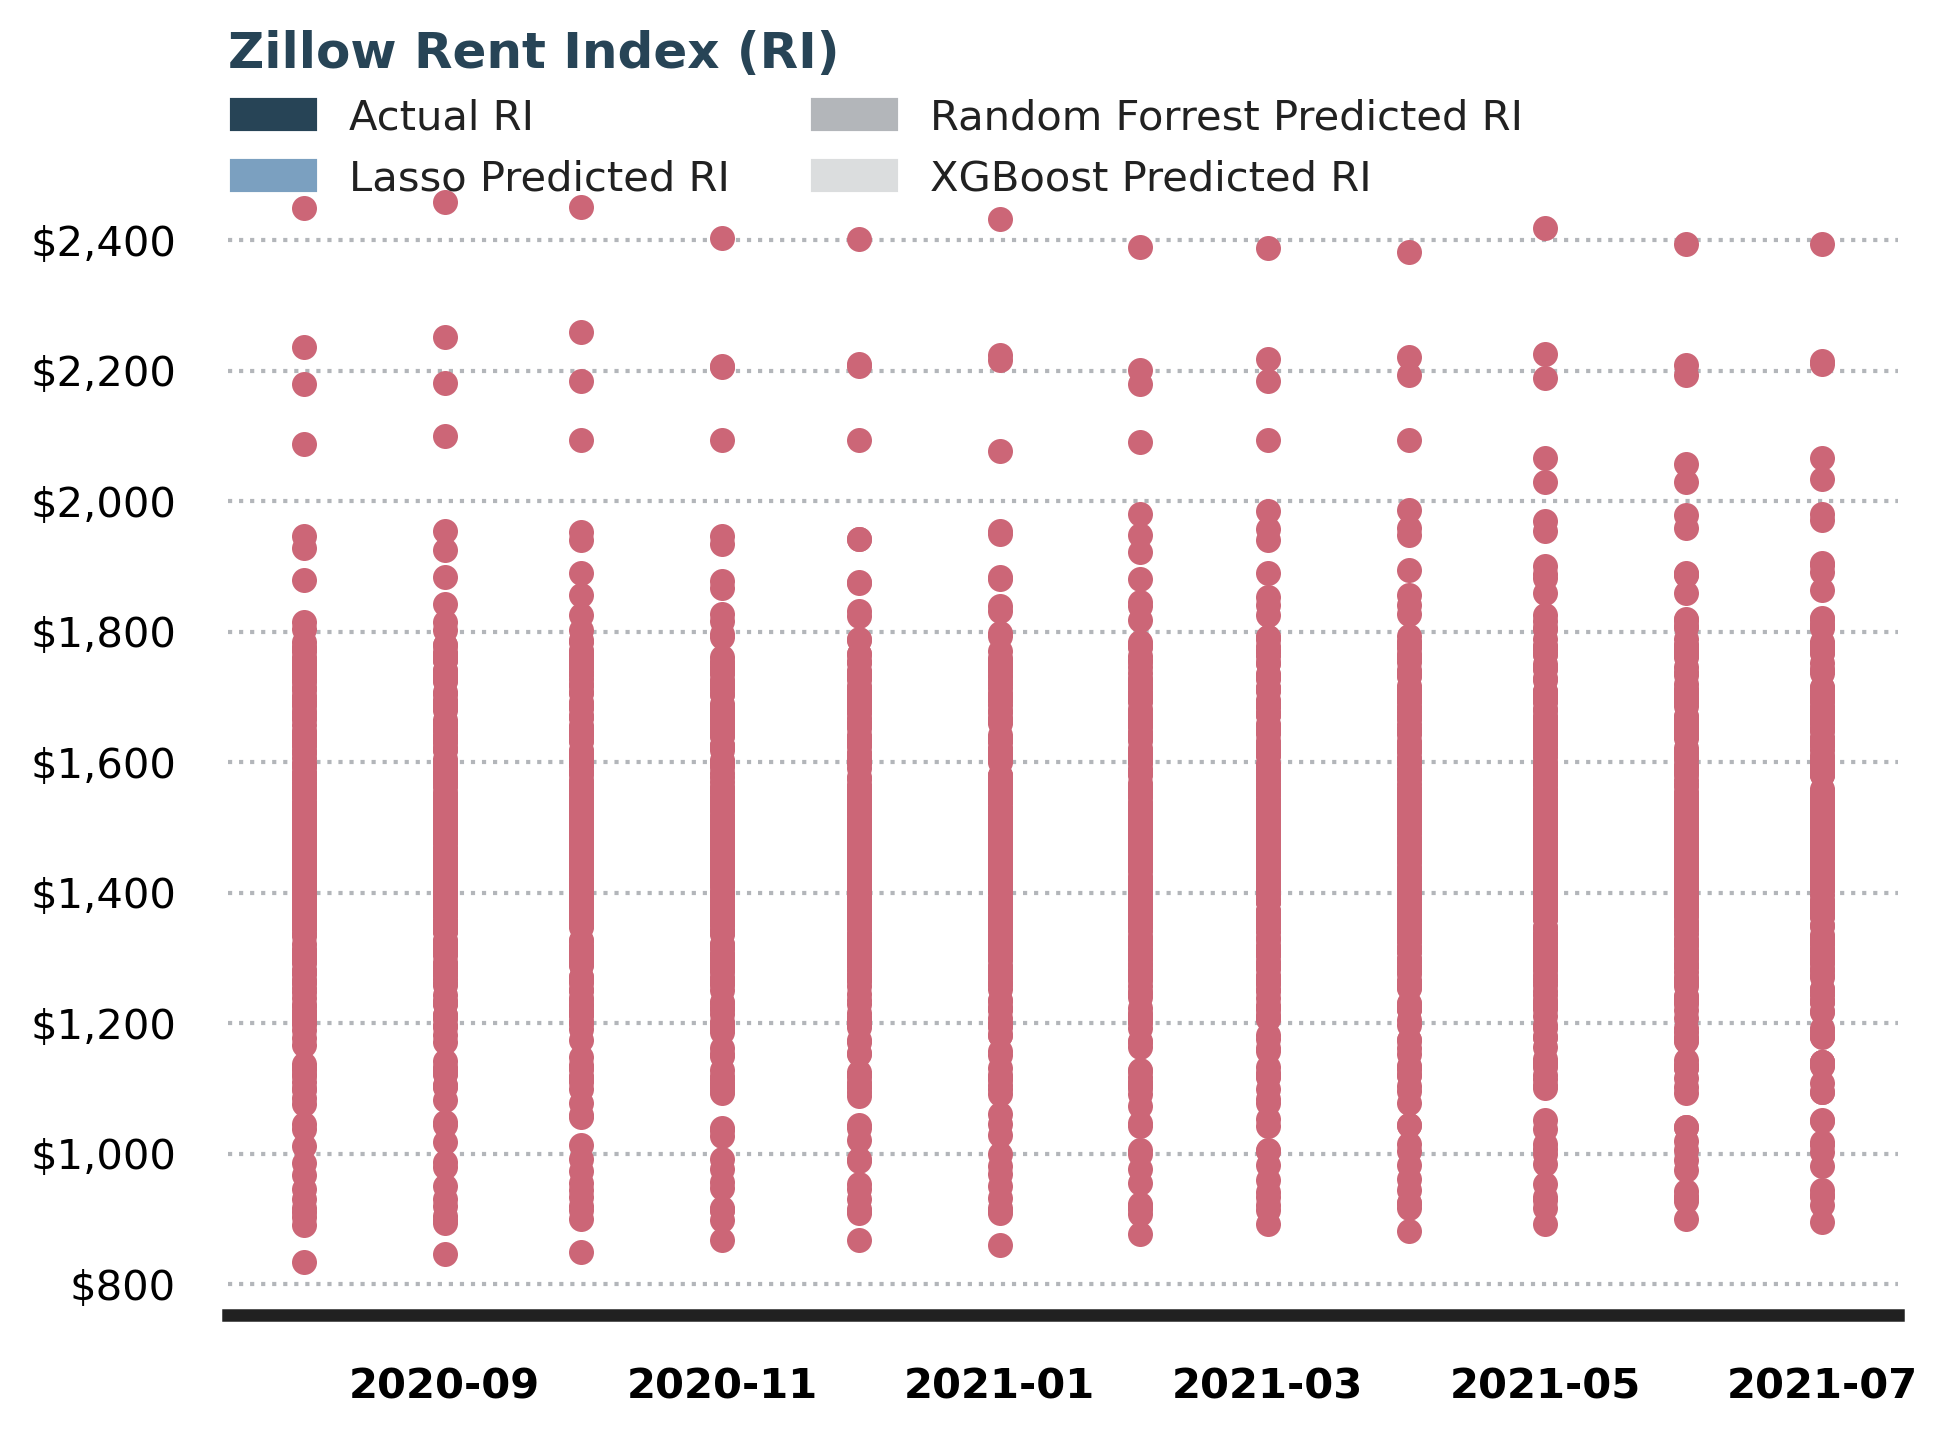

In [13]:
graph_df = zori_pred.loc[zori_pred['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)

graph_df = zori_pred.loc[zori_pred['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
graph_df = graph_df.loc[graph_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)




colors = ['#274456','#7BA0C0', '#B3B6BA','#dbddde']
fig, ax = plt.subplots()
g = sns.scatterplot(data = graph_df[graph_df['model_code']=='lasso_base'], 
                 x = 'Time',y = 'zori_ssa', 
#                  hue = 'model_code', 
#                  ci = None, 
                 linewidth=0,
                ax = ax, 
#                  palette = colors
                )
# axis spine options are ['left','right','bottom','top']
ax.spines['bottom'].set_visible(True)
# make the highlighted features bold. should be the same side with the visible spine
plt.xticks(fontweight='bold')
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'x')

g.set(xlabel='', ylabel='',title=f'Zillow Rent Index (RI)\n')

# # legend
acutal_patch = mpatches.Patch(color=colors[0], 
                           label='Actual RI')
lasso_patch = mpatches.Patch(color=colors[1], 
                           label='Lasso Predicted RI')
rf_patch = mpatches.Patch(color=colors[2], 
                           label='Random Forrest Predicted RI')
xg_patch = mpatches.Patch(color=colors[3], 
                           label='XGBoost Predicted RI')
plt.legend(handles=[acutal_patch,lasso_patch,rf_patch,xg_patch],
           loc='center left', 
           bbox_to_anchor=(-0.02, 1),frameon=False,ncol=2,
                title = '')

ax.yaxis.set_major_formatter('${x:,.0f}')

# add information from before 2016
# can we have this be percent increase
# fix the y axis to have dollar signs
plt.show()